<a href="https://colab.research.google.com/github/javmencia/RBLog/blob/main/RegressionModelExtv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Half-diagonal length of the rhombus

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta],  # Top vertex
    [beta0[0] - delta, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right

# Generate points on the inward-curving rhombus
num_points_per_curve = 8
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)


In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Calculate mu for each point on the circle

        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

        # Posterior log-probability
        posterior_betal = pm.MvNormal(f'posterior_betal_{i}', mu=mean_beta_post, cov=cov_beta_post)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0))
        posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), pm.math.dot(X, beta)))
        logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


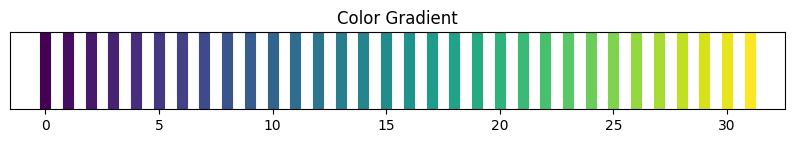

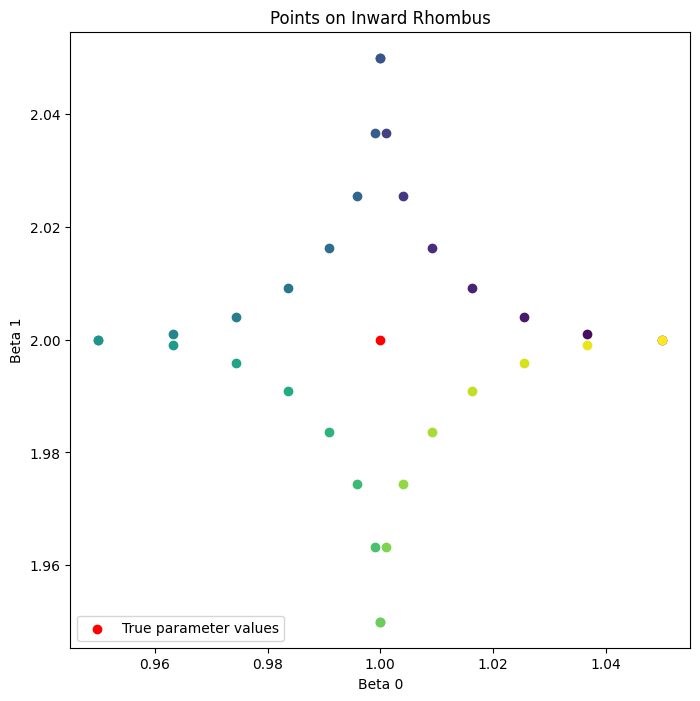

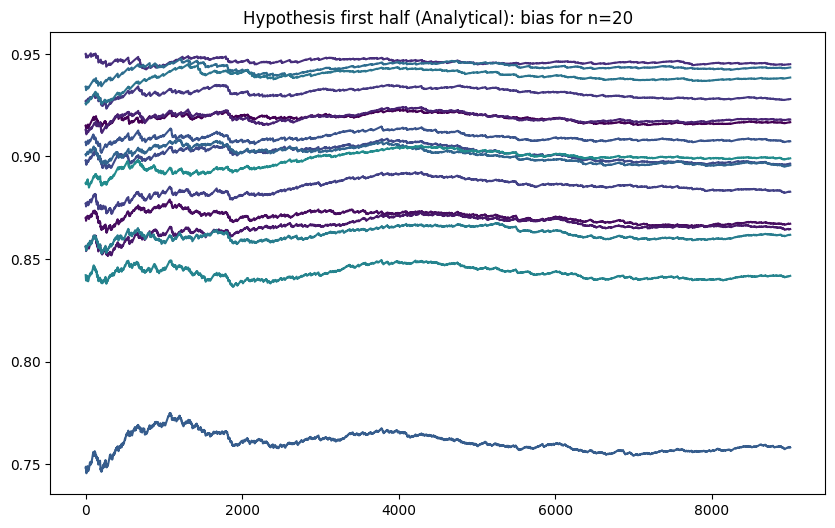

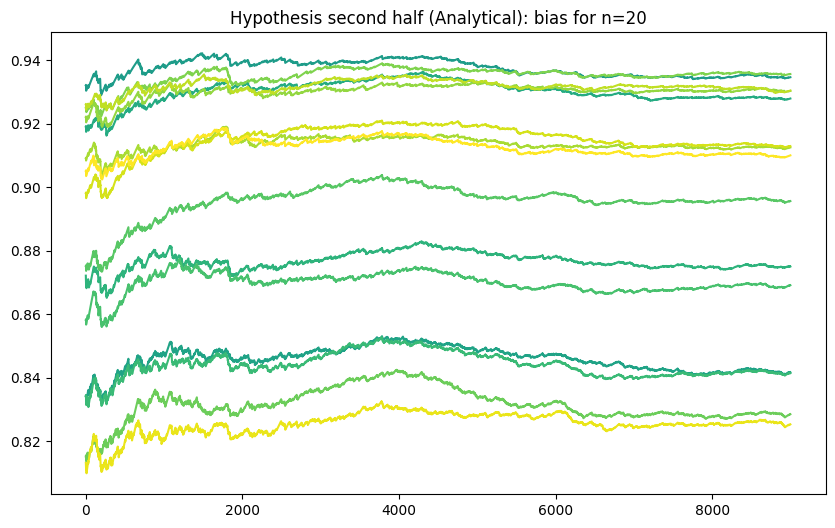

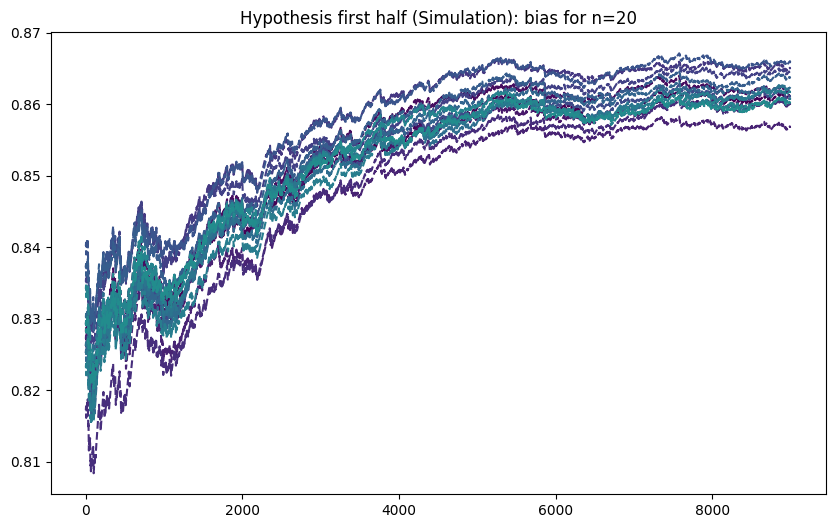

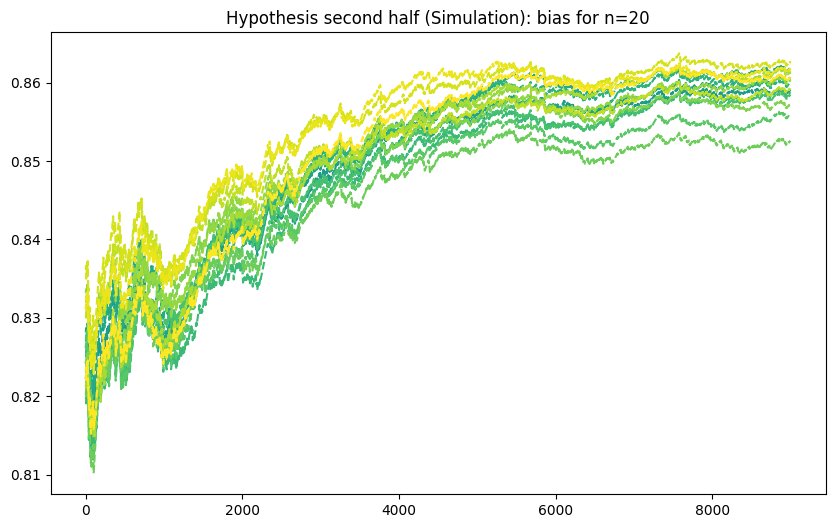

In [6]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)
# Convert lists to numpy arrays
#posterior_pds = np.array(posterior_pds)
#logBR_prior_pds = np.array(logBR_prior_pds)
#likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Calculate mu for each point on the circle

        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), mu0))


        # Posterior log-probability
        posterior_betal = pm.MvNormal(f'posterior_betal_{i}', mu=mean_beta_post, cov=cov_beta_post)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0))
        posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)
        logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), y_l).sum())
        likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


In [14]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)


posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    # Vectorize mean_beta_post calculation
    yls_stack = np.stack(yls)  # Shape: (num_points, n)
    Sigma_inv_dot_yls = np.dot(Sigma_inv, yls_stack.T).T  # Shape: (num_points, n)
    mean_beta_posts = (np.dot(cov_beta_post, np.dot(X_transpose, Sigma_inv_dot_yls.T) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean)[:, np.newaxis])).T

    print(mean_beta_posts)
    y_ls = pm.MvNormal('y_l', mu=muls, cov=(sigma0**2) * np.eye(n), shape=(num_points, n))
    posterior_betals = pm.MvNormal('posterior_betal', mu=mean_beta_posts, cov=cov_beta_post, shape = (num_points, p))
    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Calculate mu for each point on the circle
        y_l = pm.Deterministic(f'y_l_{i}', y_ls[i])
        # Likelihood
        #y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta

        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), mu0))
        # Posterior log-probability
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betals[i]), cov=(sigma**2) * np.eye(n), shape=(n,)), mu0))
        #posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)
        #logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        #likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


[[0.7739615  1.78459573]
 [0.29562119 1.77446292]
 [0.9058717  1.99612661]
 [0.93477224 1.78647853]
 [0.93689538 1.87046639]
 [0.71450888 1.81021926]
 [0.91761114 2.18632094]
 [1.55364612 2.19992379]
 [0.79783976 1.95748529]
 [0.79631045 1.60832876]
 [0.94716883 2.06914001]
 [0.68906756 1.7574428 ]
 [0.66629801 1.6855337 ]
 [0.88083209 1.84913956]
 [0.50532382 1.85760172]
 [0.88461858 1.54524148]
 [1.07836615 2.05586361]
 [0.81867477 1.97769431]
 [0.63585396 1.90815416]
 [0.74504647 2.11750532]
 [1.19803996 1.72940515]
 [0.65841674 1.78065623]
 [0.6610392  1.97923639]
 [1.00466695 1.8356524 ]
 [0.68314577 1.68112128]
 [0.26131417 1.43094993]
 [1.06499033 2.08573715]
 [1.03376002 2.28696737]
 [0.58124923 1.82414955]
 [1.00244434 2.15980105]
 [0.69316881 1.93629432]
 [1.23538697 2.2809868 ]]


Cell execution time: 1183.93 seconds


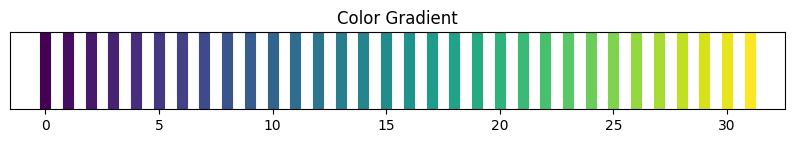

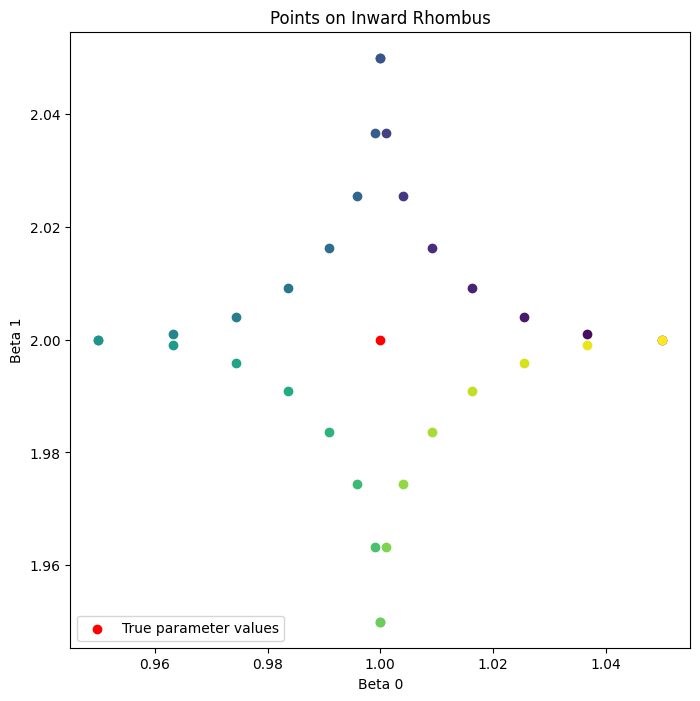

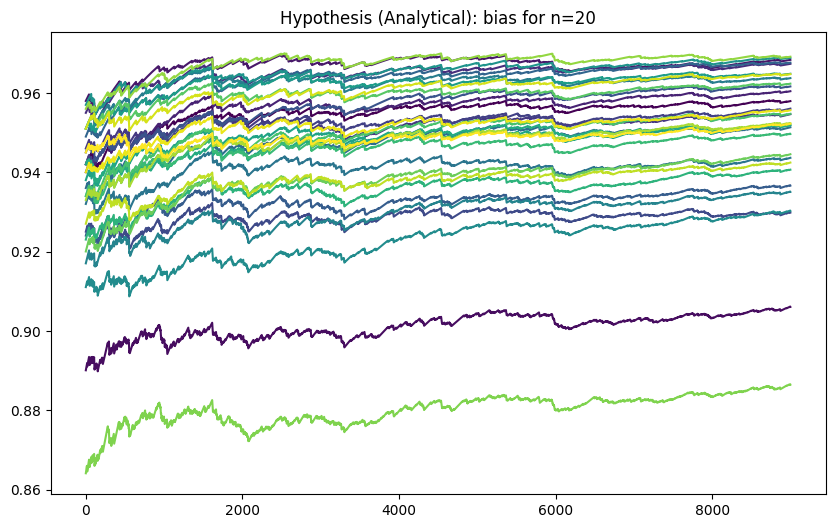

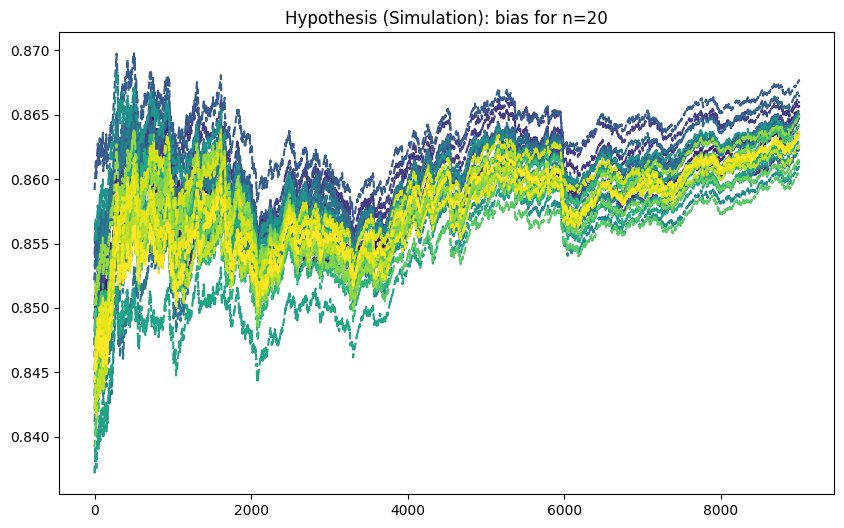

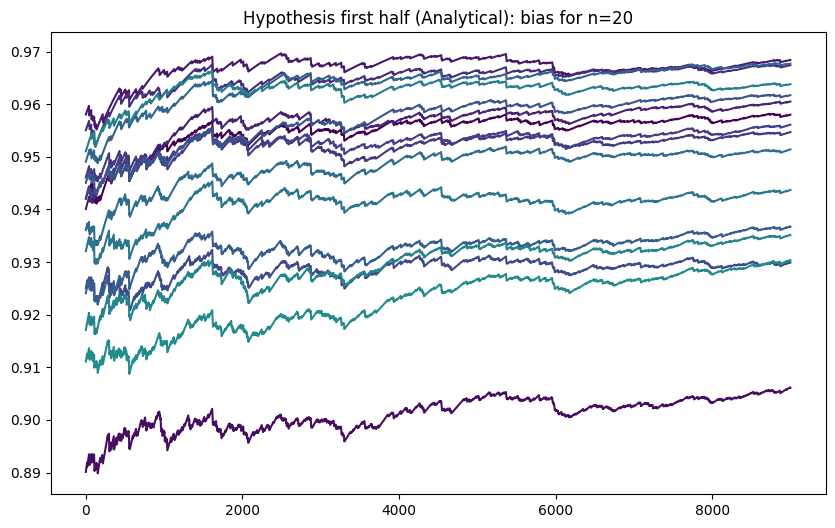

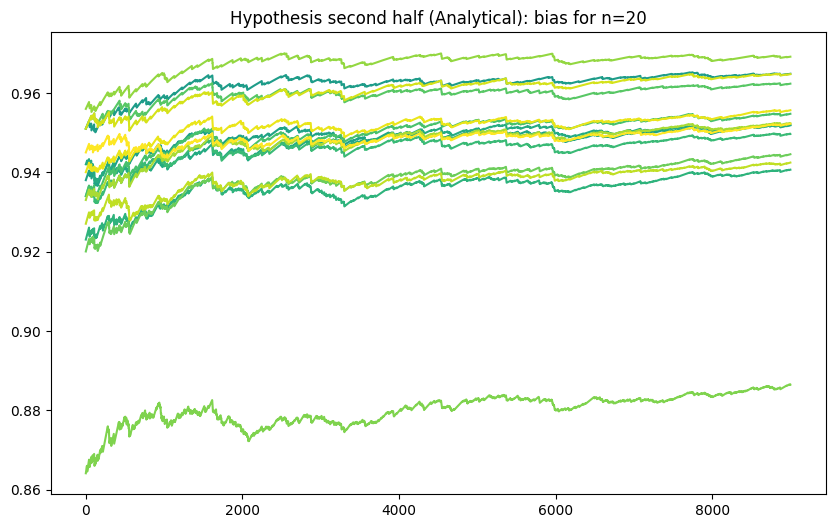

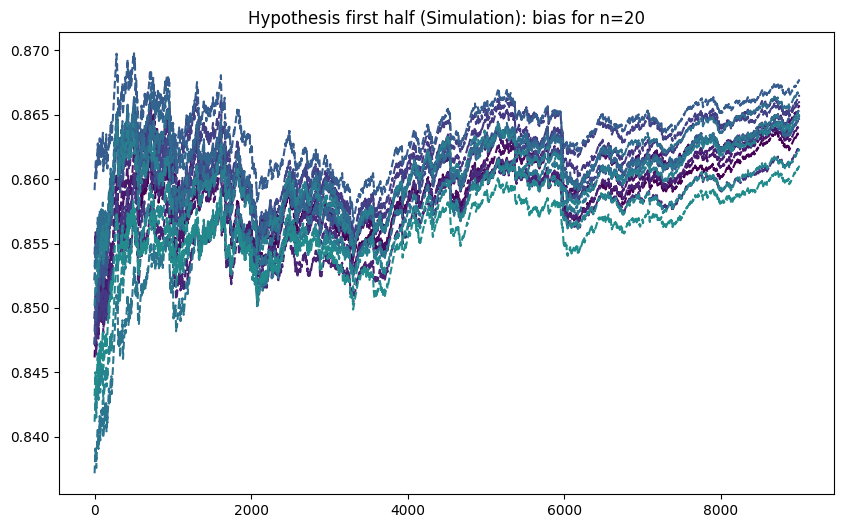

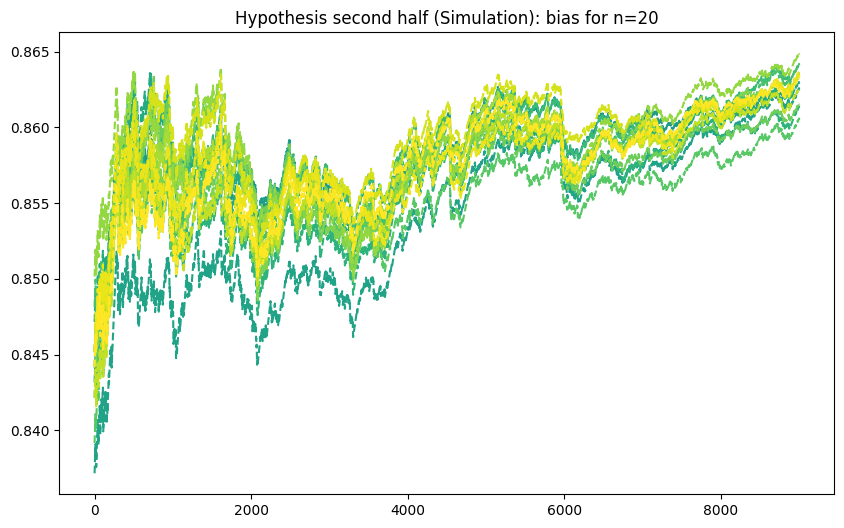

In [16]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)
# Convert lists to numpy arrays
posterior_pds = np.array(posterior_pds)
logBR_prior_pds = np.array(logBR_prior_pds)
likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

Large n

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)


posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    # Vectorize mean_beta_post calculation
    yls_stack = np.stack(yls)  # Shape: (num_points, n)
    Sigma_inv_dot_yls = np.dot(Sigma_inv, yls_stack.T).T  # Shape: (num_points, n)
    mean_beta_posts = (np.dot(cov_beta_post, np.dot(X_transpose, Sigma_inv_dot_yls.T) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean)[:, np.newaxis])).T

    print(mean_beta_posts)
    y_ls = pm.MvNormal('y_l', mu=muls, cov=(sigma0**2) * np.eye(n), shape=(num_points, n))
    posterior_betals = pm.MvNormal('posterior_betal', mu=mean_beta_posts, cov=cov_beta_post, shape = (num_points, p))
    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Calculate mu for each point on the circle
        y_l = pm.Deterministic(f'y_l_{i}', y_ls[i])
        # Likelihood
        #y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta

        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), mu0))
        # Posterior log-probability
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betals[i]), cov=(sigma**2) * np.eye(n), shape=(n,)), mu0))
        #posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)
        #logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        #likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")
